In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 使用黑体  
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号 
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix, load_npz, save_npz  # 稀疏矩阵核心库
import networkx as nx
import time

# 0.数据清洗与整理

In [64]:
#读入
products = pd.read_csv("products.csv",encoding='gbk')  #gbk编码，不是utf-8
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products = pd.read_csv('order_products_train.csv') #给的文件名多打了一个下划线

In [65]:
#描述性统计
products.describe()
#对应关系的描述

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49684.000000
mean,24844.500000,67.767308,11.728504
std,14343.834425,38.317947,5.850548
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [66]:
order_products.describe()

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00


In [67]:
aisles.describe()
#134种具体品名

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


In [68]:
departments.describe()
#说明有21类商品（如酒精饮料，冷冻产品等）

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


In [69]:
#异常值检验
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    4
dtype: int64

In [70]:
order_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [71]:
#只有product.csv中department_id有空缺,四万多条数据仅有四条空值，影响忽略不计，删去

In [72]:
# 合并商品信息
products_full = products.merge(aisles, on='aisle_id', how='left')
products_full = products_full.merge(departments, on='department_id', how='left')

order_products_full = order_products.merge(
    products_full[['product_id', 'product_name', 'aisle', 'department']],
    on='product_id', how='left'
)
#删除空值
order_products_clean = order_products_full.dropna(subset=['department']).copy()

In [73]:
order_products_clean.describe()

,order_id,product_id,add_to_cart_order,reordered
count,1.384573e+06,1.384573e+06,1.384573e+06,1.384573e+06
mean,1.706296e+06,2.555639e+04,8.758063e+00,5.985997e-01
std,9.897317e+05,1.412134e+04,7.423942e+00,4.901819e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.530000e+04,7.000000e+00,1.000000e+00
75%,2.567955e+06,3.794300e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00


In [74]:
#集合数据样例
order_products_clean.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods
5,1,13176,6,0,Bag of Organic Bananas,fresh fruits,produce
6,1,47209,7,0,Organic Hass Avocado,fresh fruits,produce
7,1,22035,8,1,Organic Whole String Cheese,packaged cheese,dairy eggs
8,36,39612,1,0,Grated Pecorino Romano Cheese,specialty cheeses,dairy eggs
9,36,19660,2,1,Spring Water,water seltzer sparkling water,beverages


In [75]:
 # 1.1 商品级交易数据（用于任务1-3）：按订单分组，生成商品列表
product_transactions = order_products_clean.groupby('order_id')['product_name'].apply(list).values.tolist()
# 1.2 商品类（department）交易数据（用于任务4）：按订单分组，生成department列表
dept_transactions = order_products_clean.groupby('order_id')['department'].unique().apply(list).values.tolist()  
# 1.3 商品类（aisle）交易数据（用于任务5）：按订单分组，生成aisle列表
aisle_transactions = order_products_clean.groupby('order_id')['aisle'].unique().apply(list).values.tolist()
# 转换为模型输入格式（One-Hot编码）
te = TransactionEncoder()
# 商品
product_te = te.fit_transform(product_transactions).astype(np.bool_)
product_df = pd.DataFrame(product_te, columns=te.columns_)
# Department
dept_te = te.fit_transform(dept_transactions)
dept_df = pd.DataFrame(dept_te, columns=te.columns_)
# Aisle
aisle_te = te.fit_transform(aisle_transactions)
aisle_df = pd.DataFrame(aisle_te, columns=te.columns_)

In [76]:
product_df.head(10)
#该矩阵十分稀疏，大部分是无效信息，在跑算法的时候运存极高，参数support不能太小

,#2 Coffee Filters,#2 Cone White Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,#NAME?,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0 Calorie Fuji Apple Pear Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,...,with Sweet Cinnamon Bunches Cereal,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 1.关联规则初步挖掘

In [77]:
order_num = order_products_clean['order_id'].nunique()
product_num = order_products_clean['product_name'].value_counts()
product_support = product_num / order_num
product_support.describe()
product_support.head(10)
#说明绝大多数的具体商品品名support都在0.05以下，可以初步考虑以0.05为min_support

Banana                    0.142719
Bag of Organic Bananas    0.117980
Organic Strawberries      0.083028
Organic Baby Spinach      0.074568
Large Lemon               0.062000
Organic Avocado           0.056467
Organic Hass Avocado      0.055583
Strawberries              0.049494
Limes                     0.045980
Organic Raspberries       0.042268
Name: product_name, dtype: float64

In [89]:
#算Φ
def calculate_phi_coefficient(rules, total_transactions):
    phi_list = []
    for idx, rule in rules.iterrows():
        A = list(rule['antecedents'])[0]  # 前件：从frozenset→列表→提取唯一元素
        B = list(rule['consequents'])[0]  # 后件：从frozenset→列表→提取唯一元素
        p_ab = rule['support']          # P(A∩B)：A和B同时出现的支持度
        p_a = rule['antecedent support']# P(A)：前件A单独出现的支持度
        p_b = rule['consequent support']# P(B)：后件B单独出现的支持度
        numerator = p_ab - (p_a * p_b)
        denominator = np.sqrt(p_a * p_b * (1 - p_a) * (1 - p_b))
        # 避免分母为0（当P(A)或P(B)为0/1时，无关联意义，φ设为0）
        if denominator == 0:
            phi_list.append(0.0)
        else:
            phi_list.append(numerator / denominator)
    
    return phi_list

def mine_association_rules(data_df, min_support, min_confidence, algorithm):
    start_time = time.time()
    # 挖掘频繁项集
    if algorithm == 'apriori':
        frequent_itemsets = apriori(data_df, min_support=min_support,use_colnames=True)
    elif algorithm == 'fp-growth':
        frequent_itemsets = fpgrowth(data_df, min_support=min_support,use_colnames=True)
   
    # 生成关联规则（仅保留2项规则：antecedents长度=1，consequents长度=1）
    rules = association_rules(
        frequent_itemsets,
        metric="confidence",
        min_threshold=min_confidence
    )
    
    # 筛选2项规则（避免多商品关联，简化分析）
    rules = rules[
        (rules['antecedents'].apply(len) == 1) & 
        (rules['consequents'].apply(len) == 1)
    ].copy()
    
    # 计算φ-coefficient（兴趣度指标）
    rules['phi_coefficient'] = calculate_phi_coefficient(rules, data_df.shape[0])

    result = rules[['antecedents','consequents','support','confidence','lift','phi_coefficient']]
    #排序
    result = result.sort_values(['support','confidence','lift','phi_coefficient'],ascending=False)
    # 计算算法用时
    elapsed_time = time.time() - start_time
    
    return {
        'frequent_itemsets': frequent_itemsets,
        'num_of_rules': len(result),         # 规则数量
        'rules': result,                     # 规则详情
        'elapsed_time': round(elapsed_time, 4)  # 运行时间（保留4位小数）
    }

In [84]:
mine_association_rules(product_df, 0.01, 0.05, "apriori")

D:\python\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


{'frequent_itemsets':       support                                      itemsets
 0    0.017514                      (100% Whole Wheat Bread)
 1    0.011737                         (2% Reduced Fat Milk)
 2    0.017163                    (Apple Honeycrisp Organic)
 3    0.029480                                   (Asparagus)
 4    0.117980                      (Bag of Organic Bananas)
 ..        ...                                           ...
 115  0.010281                (Organic Avocado, Large Lemon)
 116  0.010685       (Organic Baby Spinach, Organic Avocado)
 117  0.012492  (Organic Baby Spinach, Organic Strawberries)
 118  0.011729  (Organic Hass Avocado, Organic Strawberries)
 119  0.012728   (Organic Raspberries, Organic Strawberries)
 
 [120 rows x 2 columns],
 'num_of_rules': 32,
 'rules':                  antecedents               consequents   support  confidence  \
 7     (Organic Strawberries)  (Bag of Organic Bananas)  0.023428    0.282174   
 6   (Bag of Organic Bananas

In [85]:
#product_df矩阵过于庞大，本人的电脑性能不足，故而需要进行简化，只筛选有效的频繁项，如果大家的电脑性能足够不妨一试
def simplify_product_df(
    product_df,
    min_support=0.001,
    min_item_count=None,
    max_columns=5000
):
   
    # 1. 筛选频繁项（列）：保留出现次数≥阈值的列
    col_counts = product_df.sum(axis=0)
    total_rows = product_df.shape[0]
    
    # 设定阈值（min_item_count优先级高于min_support）
    if min_item_count is not None:
        threshold = max(min_item_count, 1)
    else:
        threshold = max(int(total_rows * min_support), 1)
    
    # 筛选列（按出现频率降序，截取前max_columns列）
    keep_cols = col_counts[col_counts >= threshold].sort_values(ascending=False).index[:max_columns]
    df_simplified = product_df[keep_cols].copy()
    
    # 2. 删除空行（无任何True的行）
    df_simplified = df_simplified[df_simplified.sum(axis=1) > 0].copy()
    
    # 3. 格式校验（确保布尔型+无空列，适配fpgrowth）
    df_simplified = df_simplified.astype(bool)  # 强制布尔型
    df_simplified = df_simplified.loc[:, df_simplified.sum(axis=0) > 0]  # 移除空列
    
    return df_simplified


product_simplified =  simplify_product_df(product_df,min_support=0.001,min_item_count=None,max_columns=5000)

In [95]:
mine_association_rules(product_simplified, 0.01, 0.05, "fp-growth")

D:\python\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


{'min_support': 0.01,
 'min_confidence': 0.05,
 'frequent_itemsets':       support                                 itemsets
 0    0.124351                 (Bag of Organic Bananas)
 1    0.058585                   (Organic Hass Avocado)
 2    0.019384                         (Cucumber Kirby)
 3    0.016010            (Organic Whole String Cheese)
 4    0.031072                              (Asparagus)
 ..        ...                                      ...
 124  0.010692                          (Limes, Banana)
 125  0.012813                     (Limes, Large Lemon)
 126  0.011262  (Organic Baby Spinach, Organic Avocado)
 127  0.017801                (Banana, Organic Avocado)
 128  0.010837           (Organic Avocado, Large Lemon)
 
 [129 rows x 2 columns],
 'num_of_rules': 38,
 'rules':                  antecedents               consequents   support  confidence  \
 15    (Organic Strawberries)  (Bag of Organic Bananas)  0.024694    0.282174   
 14  (Bag of Organic Bananas)    (Organic

## 此处仅运行两个例子，改变confidence和support并不会改变连接的顺序

# 2.可视化与兴趣度指标对比：该部分输出过于简洁，见单独上传的代码


===== apriori =====
规则数量: 32
     support  confidence      lift       phi
21  0.012156    0.264379  4.264159  0.184235
20  0.012156    0.196066  4.264159  0.184235
31  0.012728    0.301118  3.626710  0.166047
30  0.012728    0.153295  3.626710  0.166047
23  0.010281    0.182076  2.936692  0.121808
22  0.010281    0.165827  2.936692  0.121808
3   0.018444    0.331825  2.812560  0.160822
2   0.018444    0.156331  2.812560  0.160822
5   0.013566    0.320952  2.720400  0.132184
4   0.013566    0.114987  2.720400  0.132184


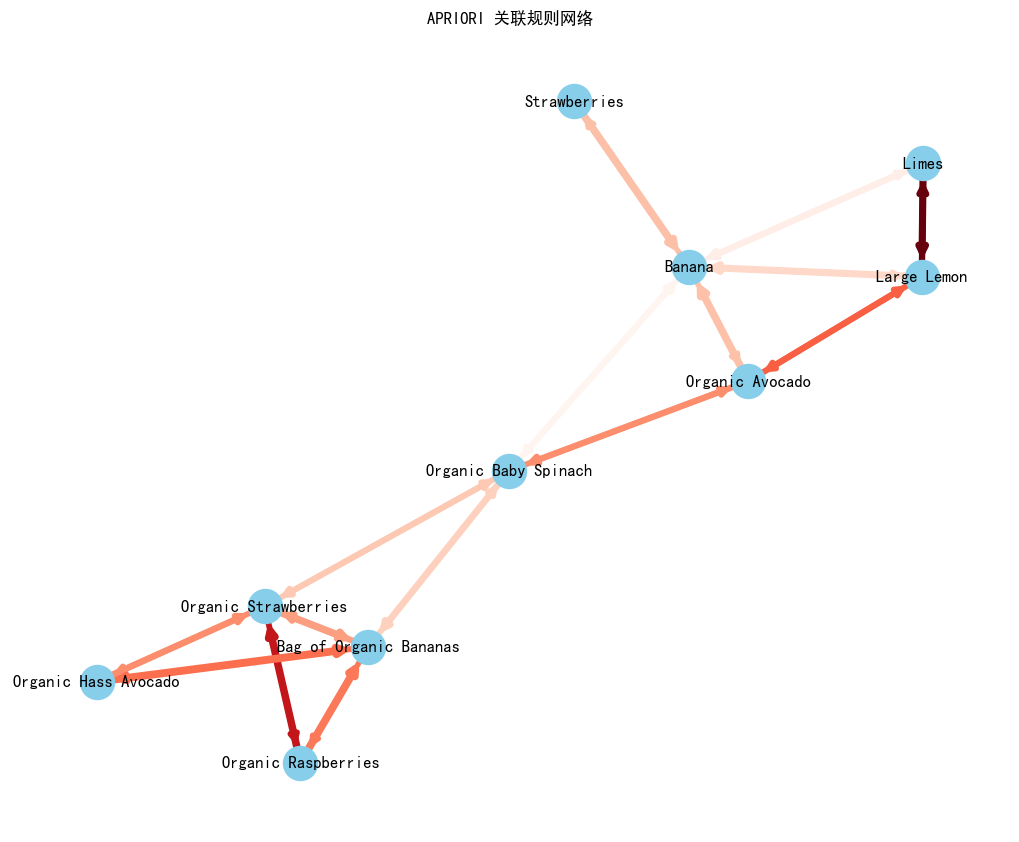


===== fp-growth =====
规则数量: 32
     support  confidence      lift       phi
25  0.012156    0.264379  4.264159  0.184235
24  0.012156    0.196066  4.264159  0.184235
7   0.012728    0.301118  3.626710  0.166047
6   0.012728    0.153295  3.626710  0.166047
31  0.010281    0.182076  2.936692  0.121808
30  0.010281    0.165827  2.936692  0.121808
1   0.018444    0.331825  2.812560  0.160822
0   0.018444    0.156331  2.812560  0.160822
5   0.013566    0.320952  2.720400  0.132184
4   0.013566    0.114987  2.720400  0.132184


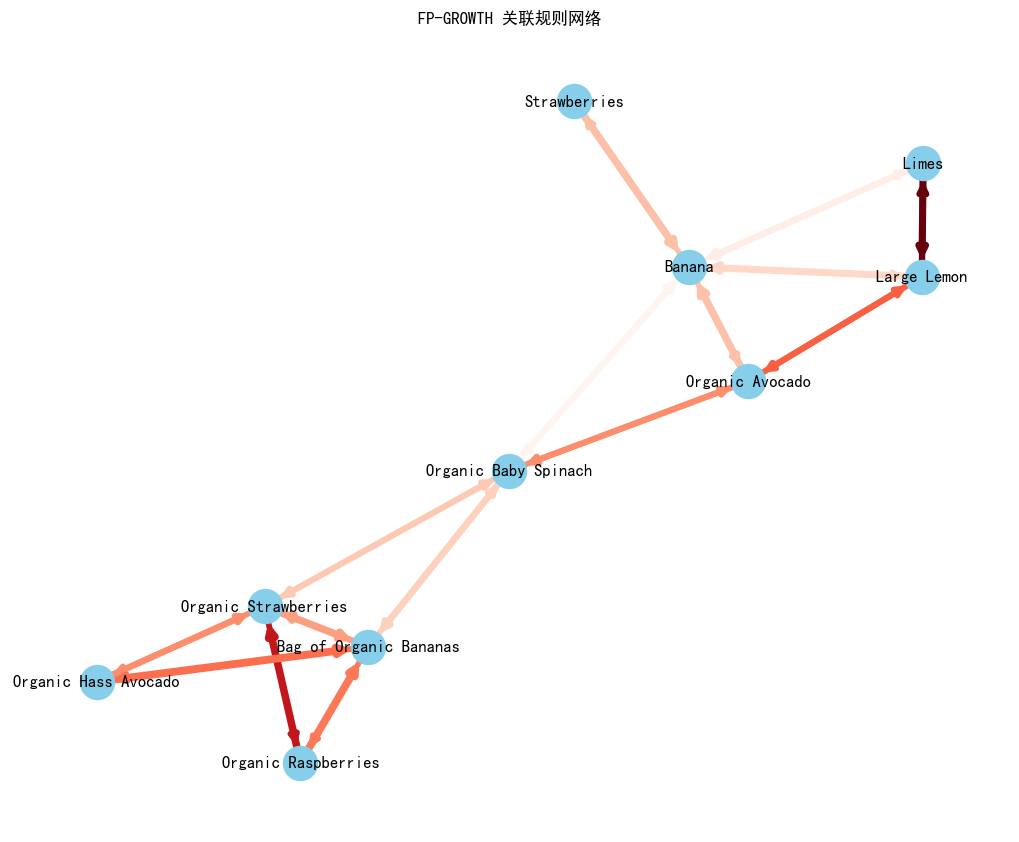


任务完成：可视化 + Top20 指标 输出成功！


In [1]:
"""
关联规则挖掘分析
任务：
1）Apriori & FP-growth 挖掘规则 + 图形可视化（节点=商品，边=规则）
2）输出最强20条规则：support, confidence, lift, phi-coefficient
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# ========== Step0. 数据加载与订单商品处理 ========== #
def load_and_transform():
    """读取数据 + 商品名称合并 + 转为交易篮结构 → One-Hot"""
    products = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\products.csv", encoding='gbk')
    deps = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\departments.csv")
    orders = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\order_products__train.csv")
    aisles = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\aisles.csv")

    # 合并所有商品属性
    df = orders.merge(products, on="product_id") \
               .merge(aisles, on="aisle_id") \
               .merge(deps, on="department_id")

    # 每个订单包含的商品列表
    transactions = df.groupby("order_id")["product_name"].apply(list).tolist()

    # One-hot 转换
    te = TransactionEncoder()
    arr = te.fit_transform(transactions)
    return pd.DataFrame(arr, columns=te.columns_).astype(bool)


def filter_low_support(df, min_support=0.001):
    """去除低频商品，减少挖掘规模"""
    freq = df.mean()  # 统计支持度
    keep_items = freq[freq >= min_support].index
    return df[keep_items]


# ========== Step1. 挖掘关联规则 ========== #
def mine_rules(df, min_sup, min_conf, method="apriori"):
    """支持 Apriori 和 FP-growth，两算法输出一致格式"""
    algo = apriori if method == "apriori" else fpgrowth

    freq = algo(df, min_support=min_sup, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)

    # 只保留 1→1 的二元规则（图模型要求）
    rules = rules[(rules.antecedents.str.len() == 1) &
                  (rules.consequents.str.len() == 1)].copy()

    # 计算 φ-coefficient
    p_ab = rules["support"]
    p_a = rules["antecedent support"]
    p_b = rules["consequent support"]
    rules["phi"] = (p_ab - p_a * p_b) / np.sqrt(p_a*p_b*(1-p_a)*(1-p_b))

    # 按重要度排序
    rules = rules.sort_values(["lift", "confidence"], ascending=False)
    return rules


# ========== Step2. 可视化网络图 ========== #
def draw_rules_graph(rules, title, top_n=30):
    """关联规则网络：节点=商品，边颜色由lift表示，边宽由confidence表示"""
    rules = rules.head(top_n)  # 只画前部分避免拥挤

    G = nx.DiGraph()
    for _, r in rules.iterrows():
        ant = list(r.antecedents)[0]
        con = list(r.consequents)[0]
        G.add_edge(ant, con, lift=r.lift, conf=r.confidence)

    pos = nx.spring_layout(G, seed=42)
    edge_color = [d["lift"] for _, _, d in G.edges(data=True)]
    edge_width = [3 + d["conf"] * 8 for _, _, d in G.edges(data=True)]

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos,
            with_labels=True,
            node_color="skyblue",
            node_size=600,
            edge_color=edge_color,
            width=edge_width,
            edge_cmap=plt.cm.Reds,
            arrowsize=12)

    plt.title(title)
    plt.show()


# ========== Step3. 主程序执行 & 输出 ========== #
MIN_SUP, MIN_CONF = 0.01, 0.05

df = load_and_transform()
df = filter_low_support(df, MIN_SUP)

for algo in ["apriori", "fp-growth"]:
    print(f"\n===== {algo} =====")
    rules = mine_rules(df, MIN_SUP, MIN_CONF, algo)
    print("规则数量:", len(rules))
    print(rules.head(10)[["support", "confidence", "lift", "phi"]])

    draw_rules_graph(rules, f"{algo.upper()} 关联规则网络")
    rules.head(20)[["support", "confidence", "lift", "phi"]] \
        .to_csv(f"{algo}_Top20.csv", index=False)

print("\n任务完成：可视化 + Top20 指标 输出成功！")


# 3. Department层次

数据加载完成。共处理 131209 个订单的部门交易数据。


--- 3.2 最终结果展示 (参数: S=0.05, C=0.2) ---
✅ Apriori 最终挖掘耗时: 1.0292 秒, 规则数: 143
✅ FP-Growth 最终挖掘耗时: 620.1768 秒, 规则数: 143

Top 5 规则对比:

[Apriori Top 5 (按 Lift 排序)]
    antecedents     consequents  support  confidence   lift  phi_coefficient
dry goods pasta    canned goods   0.0796      0.4038 1.8010           0.2134
   canned goods dry goods pasta   0.0796      0.3552 1.8010           0.2134
dry goods pasta    meat seafood   0.0595      0.3017 1.6302           0.1489
   meat seafood dry goods pasta   0.0595      0.3215 1.6302           0.1489
   canned goods    meat seafood   0.0639      0.2852 1.5409           0.1386

[FP-Growth Top 5 (按 Lift 排序)]
    antecedents     consequents  support  confidence   lift  phi_coefficient
dry goods pasta    canned goods   0.0796      0.4038 1.8010           0.2134
   canned goods dry goods pasta   0.0796      0.3552 1.8010           0.2134
dry goods pasta    meat seafood   0.0595      0.3017 1.6302           0.1489
   meat 

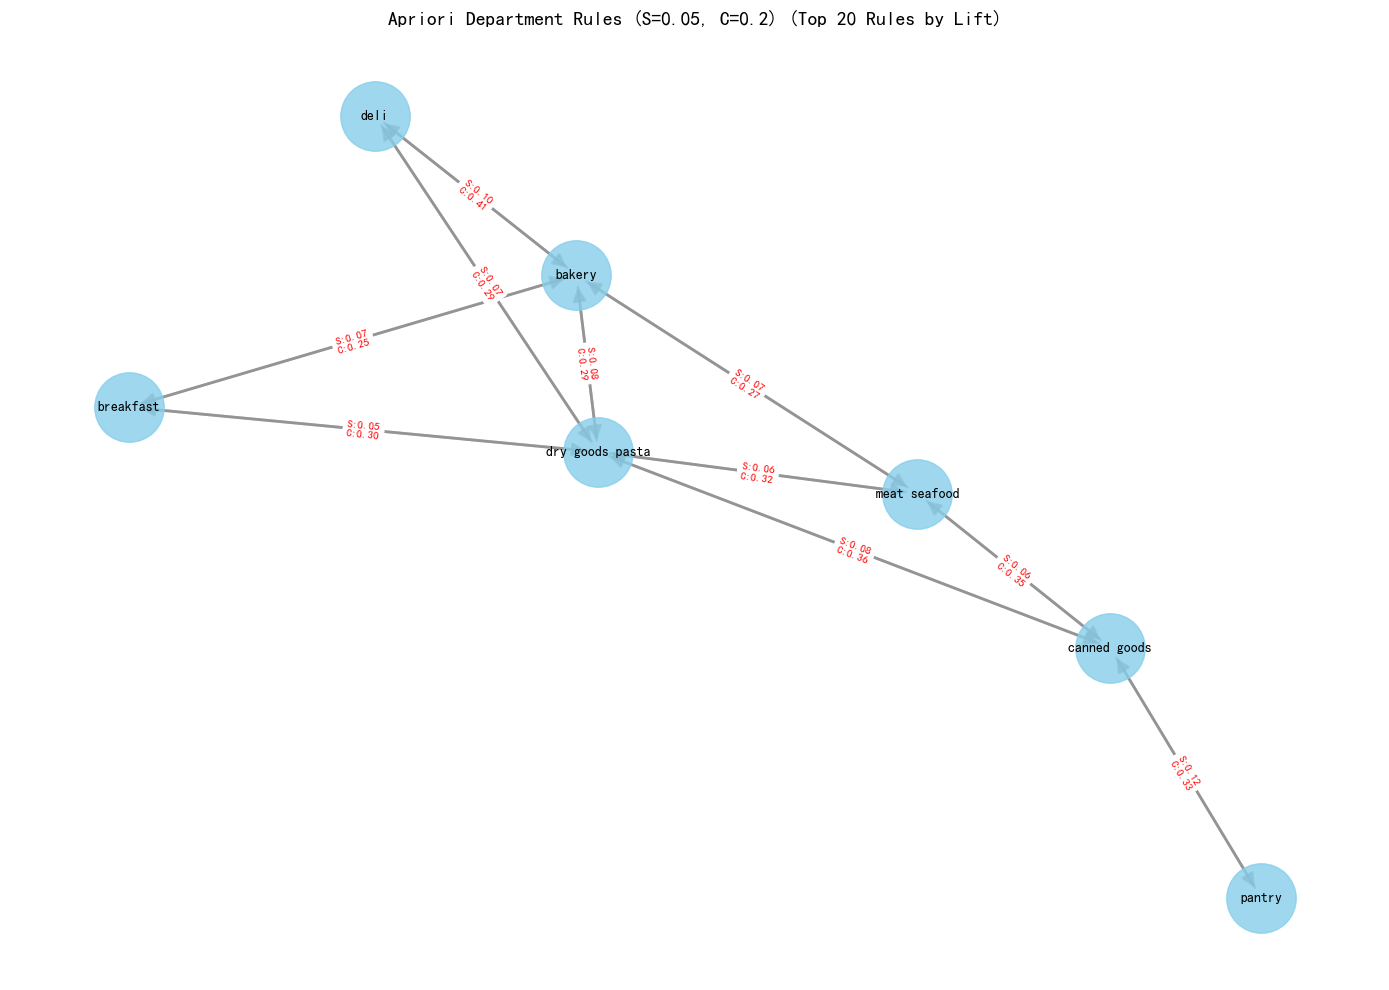

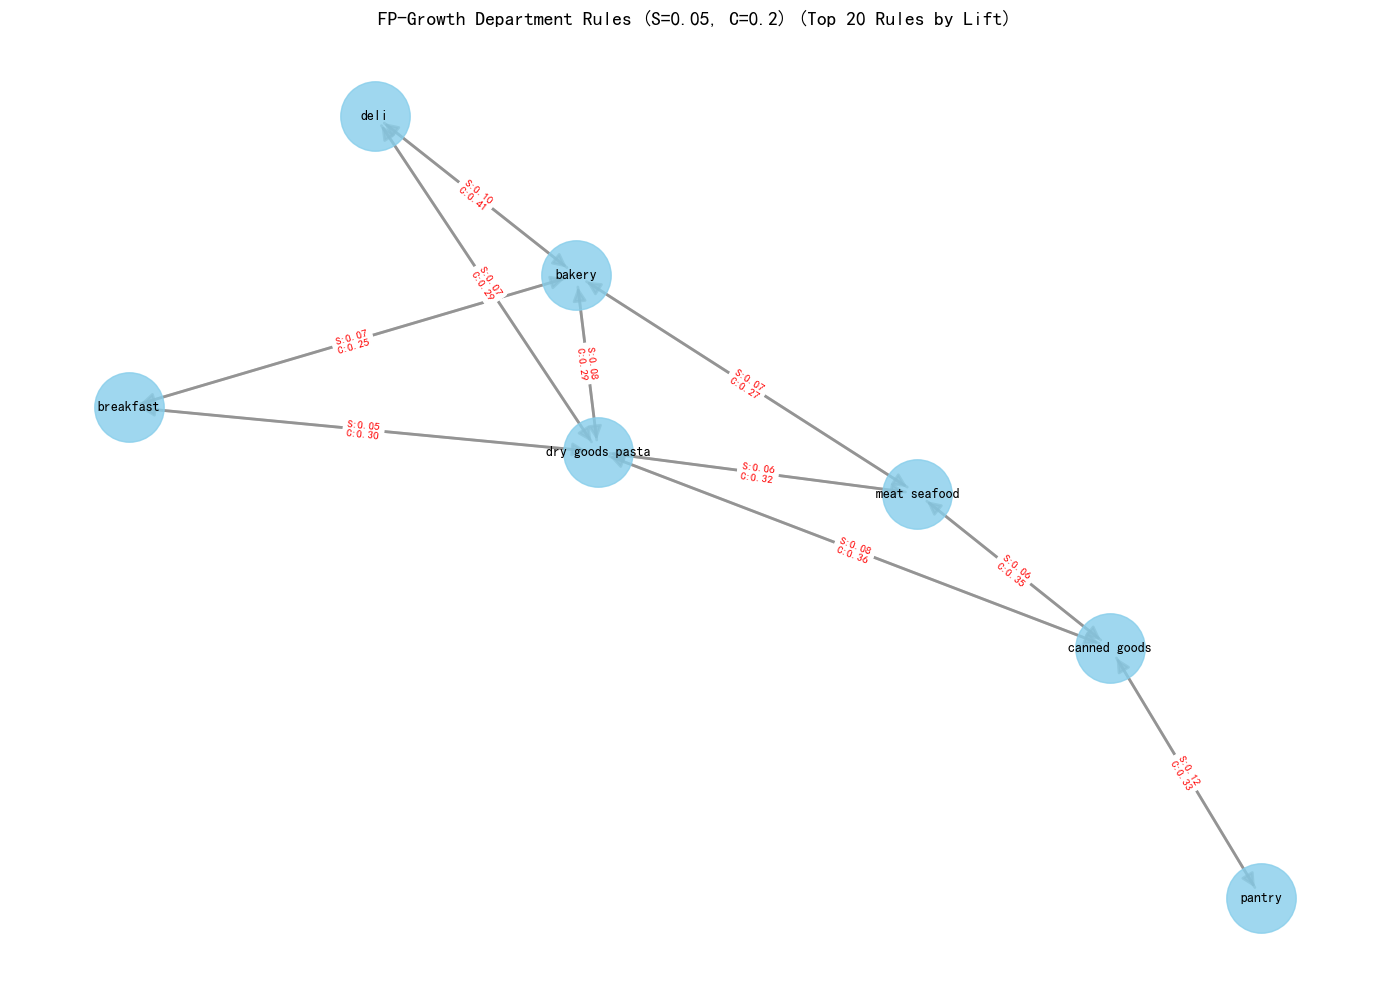

In [2]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# 设置绘图风格，确保中文正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 0. 数据加载与预处理
def prepare_data():
    """
    加载数据，清理并生成部门级别的 One-Hot 编码 DataFrame。
    """
    products = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\products.csv", encoding='gbk')
    departments = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\departments.csv")
    order_products = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\order_products__train.csv")
    
    # 关联表
    order_products_clean = order_products.merge(products, on='product_id', how='left')
    order_products_clean = order_products_clean.merge(departments, on='department_id', how='left')

    # 关键修正：填充缺失值 (NaN) 并转换为字符串，修复 TypeError
    order_products_clean['department'] = order_products_clean['department'].fillna('unknown').astype(str)
    
    # 按订单分组，生成部门列表
    dept_transactions = order_products_clean.groupby('order_id')['department'].unique().apply(list).values.tolist()
    
    # One-Hot 编码
    te = TransactionEncoder()
    dept_te = te.fit(dept_transactions).transform(dept_transactions)
    
    # 关键优化：显式转换为 bool 类型，解决 FP-Growth 算法运行缓慢的问题。
    dept_df = pd.DataFrame(dept_te, columns=te.columns_).astype(np.bool_)
    # dept_array_bool = dept_te.astype(bool)  # 先转numpy bool
    # dept_df = pd.DataFrame(dept_array_bool, columns=te.columns_)  # 再创建DataFrame
    
    return dept_df


# 1. 核心挖掘函数 (计算四指标)
def mine_association_rules(data_df, min_support, min_confidence, algorithm='fp-growth'):
    """
    执行挖掘，计算支持度, 置信度, 提升度, Phi系数四项兴趣度指标。
    """
    start_time = time.time()
    
    # 挖掘频繁项集
    if algorithm == 'apriori':
        frequent_itemsets = apriori(data_df, min_support=min_support, use_colnames=True)
    else:
        frequent_itemsets = fpgrowth(data_df, min_support=min_support, use_colnames=True)
    
    # 生成关联规则
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # 筛选 1-to-1 规则
    rules = rules[
        (rules['antecedents'].apply(len) == 1) & 
        (rules['consequents'].apply(len) == 1)
    ].copy()

    # 计算 φ-coefficient (Phi系数)
    sup_ab = rules['support']
    sup_a = rules['antecedent support']
    sup_b = rules['consequent support']
    
    numerator = sup_ab - (sup_a * sup_b)
    denominator = np.sqrt(sup_a * sup_b * (1 - sup_a) * (1 - sup_b))
    
    # 避免分母为0
    rules['phi_coefficient'] = np.where(denominator == 0, 0, numerator / denominator)

    # 结果格式化和排序
    rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
    rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])
    
    cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'phi_coefficient']
    result = rules[cols].sort_values(['lift', 'confidence'], ascending=False)
    
    elapsed_time = time.time() - start_time
    
    return {
        'rules': result,
        'elapsed_time': elapsed_time
    }

# 2. 可视化函数
def plot_rules_network(rules_df, title, top_n=20):
    """
    绘制包含 Support/Confidence 标签的网络图。
    """
    if rules_df.empty:
        print("没有规则可绘图")
        return

    top_rules = rules_df.head(top_n)
    G = nx.DiGraph()

    # 构建图，并将 Support/Confidence 存储为边属性
    for _, row in top_rules.iterrows():
        G.add_edge(row['antecedents'], row['consequents'], 
                   weight=row['lift'],
                   desc=f"S:{row['support']:.2f}\nC:{row['confidence']:.2f}")

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

    # 画节点和标签
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # 画边
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray', arrowsize=20)
    
    # 关键：画边上的文字标签 (Support/Confidence)
    edge_labels = nx.get_edge_attributes(G, 'desc')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    plt.title(f"{title} (Top {top_n} Rules by Lift)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. 算法性能对比 (参数网格搜索)
def compare_algorithms(df, params_list):
    """
    对比 Apriori 和 FP-Growth 在不同参数下的效率和规则数量
    """
    results = []
    print(f"\n--- 3.1 算法性能对比 (参数搜索) ---")

    for min_sup, min_conf in params_list:
        # --- Apriori ---
        t0 = time.time()
        fq_ap = apriori(df, min_support=min_sup, use_colnames=True)
        rules_ap = association_rules(fq_ap, metric="confidence", min_threshold=min_conf) if not fq_ap.empty else pd.DataFrame()
        time_ap = time.time() - t0

        # --- FP-Growth ---
        t0 = time.time()
        fq_fp = fpgrowth(df, min_support=min_sup, use_colnames=True)
        rules_fp = association_rules(fq_fp, metric="confidence", min_threshold=min_conf) if not fq_fp.empty else pd.DataFrame()
        time_fp = time.time() - t0

        results.append({
            'Support': min_sup,
            'Confidence': min_conf,
            'Rules_Count': len(rules_fp),
            'Time_Apriori': time_ap,
            'Time_FPGrowth': time_fp
        })
        # 精简输出
        print(f"  -> S={min_sup}, C={min_conf} | Apriori: {time_ap:.4f}s | FP-Growth: {time_fp:.4f}s | Rules: {len(rules_fp)}")

    return pd.DataFrame(results)


# 主程序：执行任务 4
if __name__ == "__main__":
    
    dept_df = prepare_data()
    
    if dept_df.empty:
        pass 
    else:
        print(f"数据加载完成。共处理 {len(dept_df)} 个订单的部门交易数据。")
        
        # --- 1. 参数搜索和对比 ---
        
        # # 设定参数网格
        # param_grid = [
        #     (0.05, 0.1), (0.05, 0.2), 
        #     (0.10, 0.1), (0.10, 0.2)
        # ]
        # comparison_results = compare_algorithms(dept_df, param_grid)
        
        # print("\n参数搜索结果表 (用于报告):")
        # print(comparison_results.to_string(index=False, float_format="%.4f"))

        # --- 2. 最终结果展示 (使用选定参数，双算法完整报告) ---
        
        # 选定最终用于深度挖掘的参数
        FINAL_SUP = 0.05
        FINAL_CONF = 0.2
        print(f"\n\n--- 3.2 最终结果展示 (参数: S={FINAL_SUP}, C={FINAL_CONF}) ---")

        # 2.1 Apriori 最终挖掘 (单独计时)
        res_ap = mine_association_rules(dept_df, FINAL_SUP, FINAL_CONF, algorithm='apriori')
        print(f"✅ Apriori 最终挖掘耗时: {res_ap['elapsed_time']:.4f} 秒, 规则数: {len(res_ap['rules'])}")
        
        # 2.2 FP-Growth 最终挖掘 (单独计时)
        res_fp = mine_association_rules(dept_df, FINAL_SUP, FINAL_CONF, algorithm='fp-growth')
        print(f"✅ FP-Growth 最终挖掘耗时: {res_fp['elapsed_time']:.4f} 秒, 规则数: {len(res_fp['rules'])}")

        # --- 3. 报告展示 (Top 5 和 可视化) ---
        
        if not res_ap['rules'].empty and not res_fp['rules'].empty:
            
            print("\nTop 5 规则对比:")
            
            # Apriori Top 5
            print("\n[Apriori Top 5 (按 Lift 排序)]")
            print(res_ap['rules'].head(5).to_string(index=False, float_format="%.4f"))
            
            # FP-Growth Top 5
            print("\n[FP-Growth Top 5 (按 Lift 排序)]")
            print(res_fp['rules'].head(5).to_string(index=False, float_format="%.4f"))

            # 关键修正：将 Top 20 规则及其四项指标保存到 CSV 文件 (满足任务要求)
            cols_to_save = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'phi_coefficient']
            
            res_ap['rules'][cols_to_save].head(20).to_csv('Apriori_Top20_Rules_Department.csv', index=False, float_format="%.4f")
            res_fp['rules'][cols_to_save].head(20).to_csv('FPGrowth_Top20_Rules_Department.csv', index=False, float_format="%.4f")
            print("\n✅ 已将 Apriori 和 FP-Growth 的 Top 20 规则及四项指标保存至 CSV 文件。")
            
            # --- 4. 可视化：分别展示两种算法的结果 (小幅改动实现) ---
            
            # Apriori 可视化
            plot_rules_network(res_ap['rules'], title=f"Apriori Department Rules (S={FINAL_SUP}, C={FINAL_CONF})")
            
            # FP-Growth 可视化
            plot_rules_network(res_fp['rules'], title=f"FP-Growth Department Rules (S={FINAL_SUP}, C={FINAL_CONF})")

        else:
            print("未发现满足条件的规则，请调整支持度或置信度参数。")

# 4. Aisle层次：内存不足跑不通，该部分代码以单独文件上传

In [3]:
"""
Instacart 购物篮数据关联规则挖掘（Aisle 层级）
Apriori & FP-growth
包含：性能对比表 + Top20指标 + 网络图可视化
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import networkx as nx
import matplotlib.pyplot as plt
import time


# ========== Step0. 数据加载与 aisle 映射 ========== #
def load_aisle_transactions():    
    products = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\products.csv", encoding='gbk')
    orders = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\order_products__train.csv")
    aisles = pd.read_csv(r"D:\Desktop\数据挖掘_小组大作业2\instacart\aisles.csv")
    
    # 合并并保留 aisle_id
    df = orders.merge(products, on='product_id') \
               .merge(aisles, on='aisle_id')

    # 每个订单 → aisle名称列表
    transactions = df.groupby("order_id")["aisle"].apply(list).tolist()

    # One-hot 编码
    te = TransactionEncoder()
    arr = te.fit_transform(transactions)
    return pd.DataFrame(arr, columns=te.columns_).astype(bool)


# ========== Step1. 关联规则挖掘封装 ========== #
def run_association(df, min_sup, min_conf, method="apriori"):
    algo = apriori if method == "apriori" else fpgrowth
    t0 = time.time()
    freq = algo(df, min_support=min_sup, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
    elapsed = time.time() - t0

    # 仅保留1→1规则
    rules = rules[(rules.antecedents.str.len() == 1) &
                  (rules.consequents.str.len() == 1)].copy()

    # 计算 φ-coefficient（修正正确版本）
    p_ab, p_a, p_b = rules.support, rules["antecedent support"], rules["consequent support"]
    rules["phi"] = (p_ab - p_a * p_b) / np.sqrt(p_a*p_b*(1-p_a)*(1-p_b))

    return rules.sort_values(["confidence", "lift"], ascending=False), elapsed


# ========== Step2. 性能测试对比 ========== #
def benchmark(df, params, method):
    results = []
    for s, c in params:
        rules, t = run_association(df, s, c, method)
        results.append({
            "method": method,
            "min_support": s,
            "min_confidence": c,
            "num_rules": len(rules),
            "elapsed_time(sec)": round(t, 3)
        })
    return pd.DataFrame(results)


# ========== Step3. 网络可视化 ========== #
def draw_graph(rules, title, top_n=20):
    rules = rules.head(top_n)
    G = nx.DiGraph()

    for _, r in rules.iterrows():
        a = list(r.antecedents)[0]
        c = list(r.consequents)[0]
        G.add_edge(a, c, conf=r.confidence, lift=r.lift)

    pos = nx.spring_layout(G, seed=42)
    edge_w = [2 + d["conf"]*8 for _,_,d in G.edges(data=True)]
    edge_c = [d["lift"] for _,_,d in G.edges(data=True)]

    plt.figure(figsize=(11, 9))
    nx.draw(G, pos,
            with_labels=True,
            node_color="skyblue",
            edge_color=edge_c,
            width=edge_w,
            node_size=2200,
            edge_cmap=plt.cm.magma,
            arrowsize=15)
    plt.title(title)
    plt.show()


# ========== 主程序：统一运行 Apriori + FP-growth ========== #
PARAMS = [(0.01, 0.05), (0.01, 0.1), (0.02, 0.05),
          (0.02, 0.1), (0.05, 0.05), (0.05, 0.1)]

df = load_aisle_transactions()

perf_apriori = benchmark(df, PARAMS, "apriori")
perf_fpgrowth = benchmark(df, PARAMS, "fp-growth")

print("\n========== 性能对比表 ==========")
perf_total = pd.concat([perf_apriori, perf_fpgrowth], ignore_index=True)
print(perf_total)

perf_total.to_csv("Performance_compare.csv", index=False)


# ========== Top20指标 + 可视化 ========== #
BEST_SUP, BEST_CONF = 0.01, 0.05

rules_a, _ = run_association(df, BEST_SUP, BEST_CONF, "apriori")
rules_f, _ = run_association(df, BEST_SUP, BEST_CONF, "fp-growth")

print("\n========== Top20 Apriori ==========")
print(rules_a.head(20)[["support", "confidence", "lift", "phi"]])
print("\n========== Top20 FP-growth ==========")
print(rules_f.head(20)[["support", "confidence", "lift", "phi"]])

rules_a.head(20).to_csv("Apriori_Aisle_Top20.csv", index=False)
rules_f.head(20).to_csv("FP_Aisle_Top20.csv", index=False)

# 可视化输出
draw_graph(rules_a, "Aisle - Apriori 规则网络图")
draw_graph(rules_f, "Aisle - FP-growth 规则网络图")

print("\n任务完成 ✓ 图像 + 指标结果已导出！")


MemoryError: Unable to allocate 12.2 GiB for an array with shape (24989, 4, 131209) and data type bool